## Image Pipeline

with datasets and dataloaders for labeled and unlabeled images and with data augmentation

Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [1]:
import os
import glob

from pathlib import Path

from skimage import io

import matplotlib.pyplot as plt

import torch, torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

print(f'torch version {torch.__version__}')
print(f'torchvision version {torchvision.__version__}')

torch version 1.7.0
torchvision version 0.8.1


## Define Dataset classes

In [2]:
# reproducibility 
torch.manual_seed(4247)
shuffle = False

In [3]:
class UnlabeledDataset(Dataset): 
        
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.item_list = self.read_filenames()
        
    def __len__(self):
        if self.item_list == None:
            return 0
        return len(self.item_list)
    
    def __getitem__(self, idx):

        if self.item_list == None:
            return None
        
        item_path = os.path.join(self.root_dir, self.item_list[idx])
        # print(item_path)
        sample = io.imread(item_path)
        if self.transform:
            #sample = torch.from_numpy(sample)
            sample = self.transform(sample)
            
        return sample
                
    def read_filenames(self):
        return [f.split(os.path.sep)[-1] for f in glob.glob(os.path.join(self.root_dir, '*.jpg'))] 
        
        
class LabeledDataset(UnlabeledDataset):   
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform)
    
    def __getitem__(self, idx):
        if self.item_list == None:
            return None
        
        item_name = self.item_list[idx]
        
        # labels: 0: benign, 1: malign
        label = self.getlabel(item_name)

        item_path = os.path.join(self.root_dir, item_name)
        # print(item_path)
        sample = io.imread(item_path)
        
        if self.transform:
            #sample = torch.from_numpy(sample)
            sample = self.transform(sample)
        
        return {'image': sample, 'label': label}
    
    def getlabel(self, name):
        # label is coded in image name like : 9_0.jpg, 10_1.jpg (0->benign, 1->malign)
        # inspection of file names says that even numbers are 0 and odd numbers are 1, 
        # so we could get the label from the index of the item array, but let's use standard string splitting 
        label = name.split('.jpg')[0].split('_')[1]
        return label
        
    
           

## Define Data Loaders

In [4]:
notebook_dir = os.path.dirname(os.path.realpath('__file__'))
unlabeled_dir = os.path.join(Path(notebook_dir).parent, 'data', 'MelanomaDetection', 'unlabeled')
labeled_dir = os.path.join(Path(notebook_dir).parent, 'data', 'MelanomaDetection', 'labeled')
# print(unlabeled_dir)
# print(labeled_dir)

In [5]:
# create data loaders
batch_size = 4

unlabeled_dataloader = DataLoader(
    dataset=UnlabeledDataset(unlabeled_dir), 
    batch_size=batch_size, 
    shuffle=shuffle, 
    num_workers=0
)
labeled_dataloader = DataLoader(
    dataset=LabeledDataset(labeled_dir), 
    batch_size=batch_size, 
    shuffle=shuffle, 
    num_workers=0
)

## 

## Define some Augmentations

In [6]:
# test some transformations from torchvision.transforms

img_size = 32

# crop size
size = 30
randomCrop = transforms.RandomResizedCrop(size=size)

padding = 32
pad = transforms.Pad(50, fill=0, padding_mode='edge')
randomRotate = transforms.RandomRotation(degrees=(0, 30), expand=True)

randomHorizontalFlip = transforms.RandomHorizontalFlip(p=0.5)
randomColorJitter = transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
gaussianBlur = transforms.GaussianBlur(kernel_size=3)
                                         
composed = transforms.Compose([
    transforms.ToPILImage(),
    # randomCrop, 
    pad,
    randomRotate,
    transforms.CenterCrop(img_size),
    randomHorizontalFlip,
    randomColorJitter,
    gaussianBlur,
    transforms.ToTensor()
])

In [7]:
# creat data loaders
batch_size = 4

transformed_unlabeled_dataloader = DataLoader(
    dataset=UnlabeledDataset(unlabeled_dir, transform=composed), 
    batch_size=batch_size, 
    shuffle=shuffle, 
    num_workers=0
)
transformed_labeled_dataloader = DataLoader(
    dataset=LabeledDataset(labeled_dir, transform=composed),
    batch_size=batch_size, 
    shuffle=shuffle, 
    num_workers=0
)

In [8]:
tud = iter(transformed_unlabeled_dataloader)
tld = iter(transformed_labeled_dataloader)

## Show Images

In [9]:
# show all images of a batch
def show_images(images, labels=None, fig_title=None):
    batch_size = len(images)
    cols = 4
    rows = batch_size // cols + 1
    if batch_size%cols == 0:
        rows = batch_size // cols 
    
    fig = plt.figure()
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*cols))

    if fig_title is not None:
        fig.suptitle(fig_title, fontsize=20, y=0.7)
        
    for i in range(batch_size):
        
        if rows == 1:
            ax = axes[i]
        else:
            ax = axes[i//cols, i%cols]
        title = f'Sample #{i+1}'
        if labels:
            title = f'{title}\nlabel: {labels[i]}'
        ax.set_title(title, fontsize=12)
        ax.axis('off')
        ax.imshow(images[i], aspect='equal')
        
        
    # if there are remaining slots
    for i in range(batch_size, rows*cols):
        ax = axes[i//cols, i%cols]
        ax.axis('off')
        
    plt.tight_layout()
    fig.subplots_adjust()
 
    plt.show()
    

def show_batch(dataloader, transformed=False, title=None):
    data_iter = iter(dataloader)
    batch = next(data_iter)
 
    images = None
    labels = None
    if type(batch) is dict:
        images = batch['image']
        labels = batch['label']
    else:
        images = batch  
        
    if transformed:
        # toPILImage transformation return images with dimensions [channels, height, width]
        # -> permute [batch_size, channels, height, width] to [batch_sizechannels, height, width, channels]
        # to show the images with matplotlib
        images = images.permute(0, 2, 3, 1)
        
    show_images(images, labels, title)
    

<Figure size 432x288 with 0 Axes>

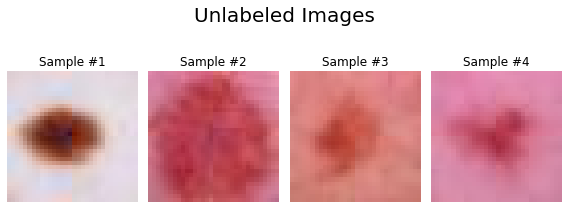

In [10]:
title = 'Unlabeled Images'
show_batch(unlabeled_dataloader, title=title)

<Figure size 432x288 with 0 Axes>

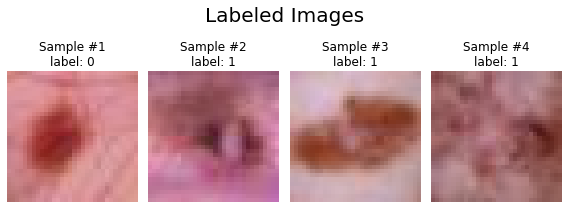

In [11]:
title = 'Labeled Images'
show_batch(labeled_dataloader, title=title)

<Figure size 432x288 with 0 Axes>

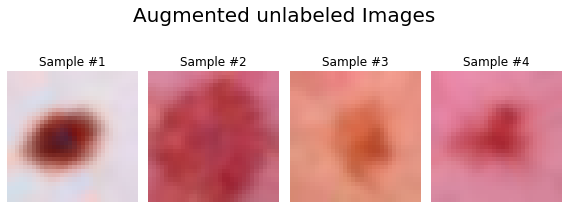

In [12]:
title = 'Augmented unlabeled Images'
show_batch(transformed_unlabeled_dataloader, transformed=True, title=title)

<Figure size 432x288 with 0 Axes>

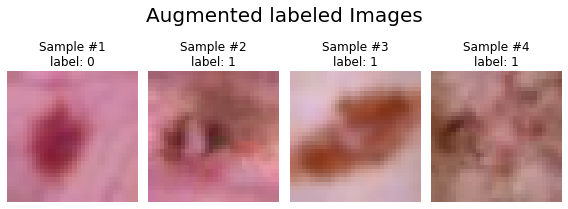

In [13]:
title='Augmented labeled Images'
show_batch(transformed_labeled_dataloader, transformed=True, title=title)